# DC DATA - Collection / Cleaning / Preprocessing

## Imports

In [387]:
import pandas as pd
import numpy as np
import pandas as pd
import os
from sqlalchemy import create_engine
from DealMatch.database_connector import db_connector
import os
from dotenv import load_dotenv
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
dbConnection = db_connector()

## DC Database queries

In [4]:
query_investor_locations = """
        SELECT * 
        FROM companies c 
        LEFT JOIN invest_profiles ip ON ip.company_id = c.id
        LEFT JOIN invest_profile_locations ipl ON ipl.invest_profile_id = ip.id 
        LEFT JOIN invest_profile_countries ipc ON ipc.invest_profile_location_id = ipl.id 
        LEFT JOIN countries c2 ON c2.id = ipc.country_id 
        WHERE c.company_category_id = 1; 
"""

In [484]:
query_investor_deals = """
        SELECT * 
        FROM companies c 
        LEFT JOIN deals d ON d.company_id = c.id 
        LEFT JOIN deal_stages ds ON ds.id = d.deal_stage_id 
        LEFT JOIN deal_types dt ON dt.id = d.deal_type_id 
        LEFT JOIN deal_lost_reasons dlr ON dlr.id = d.lost_reason_id 
        LEFT JOIN countries c2 ON d.target_country_id = c2.id 
        LEFT JOIN regions r ON d.target_region_id = r.id 
        JOIN deal_sectors ds2 ON ds2.deal_id = d.id 
        JOIN sectors s ON s.id = ds2.sector_id 
        JOIN deal_subsectors ds3 ON ds2.id = ds3.deal_sector_id 
        JOIN subsectors s2 ON s2.id = ds3.subsector_id 
        WHERE c.company_category_id = 1;
"""

In [6]:
query_invest_profile_keywords = """
        SELECT * 
        FROM companies c 
        LEFT JOIN invest_profiles ip ON ip.company_id = c.id
        LEFT JOIN invest_profile_keywords ipk ON ipk.invest_profile_id = ip.id 
        LEFT JOIN keywords k ON k.id = ipk.keyword_id 
        WHERE c.company_category_id = 1;
"""

In [7]:
query_invest_profile_sectors_subsectors = """
        SELECT * 
        FROM companies c 
        LEFT JOIN invest_profiles ip ON ip.company_id = c.id
        LEFT JOIN invest_profile_sectors ips ON ips.invest_profile_id = ip.id 
        LEFT JOIN sectors s ON s.id = ips.sector_id 
        LEFT JOIN invest_profile_subsectors ips2 ON ips2.invest_profile_sector_id = ips.id 
        LEFT JOIN subsectors s2 ON s2.id = ips2.subsector_id 
        WHERE c.company_category_id = 1;
"""

In [8]:
query_invest_profile_transaction = """
        SELECT * 
        FROM companies c 
        LEFT JOIN invest_profiles ip ON ip.company_id = c.id
        LEFT JOIN invest_profile_tx_types iptt ON iptt.invest_profile_id = ip.id 
        LEFT JOIN tx_types tt ON tt.id = iptt.tx_type_id 
        LEFT JOIN invest_profile_stake_types ipst ON ipst.invest_profile_id = ip.id 
        LEFT JOIN stake_types st ON st.id = ipst.stake_type_id 
        WHERE c.company_category_id = 1;
"""

## RAW Dataframes

In [9]:
investor_locations = pd.read_sql(query_investor_locations, dbConnection);
investor_locations.head()

,id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,id,company_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at,updated_at,deleted_at,is_deleted,id,invest_profile_id,continent_id,is_excluded,created_at,updated_at,deleted_at,is_deleted,id,invest_profile_location_id,country_id,is_excluded,created_at,updated_at,deleted_at,is_deleted,id,iso_alpha2,iso_alpha3,name_en,name_de,name_fr,name_es,phone_country_code,continent_id
0,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,6.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,5.0,1.0,40.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,40.0,AT,AUT,Austria,Österreich,Autriche,Austria,43,6.0
1,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,6.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,8.0,1.0,208.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,208.0,DK,DNK,Denmark,Dänemark,Danemark,Dinamarca,45,6.0
2,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,6.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4.0,1.0,246.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,246.0,FI,FIN,Finland,Finnland,Finlande,Finlandia,358,6.0
3,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,6.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,11.0,1.0,250.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,250.0,FR,FRA,France,Frankreich,France,Francia,33,6.0
4,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,6.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,276.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,276.0,DE,DEU,Germany,Deutschland,Allemagne,Alemania,49,6.0


In [14]:
investor_locations.to_excel('investor_locations.xlsx', encoding="UTF-8")

In [485]:
investor_deals = pd.read_sql(query_investor_deals, dbConnection);
investor_deals.head()

,id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,id,company_id,name,deal_type_id,deal_stage_id,is_lost,lost_reason_id,comment,target_company_id,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_region_id,target_zipcode,crm_id,parent_crm_id,crm_created_at,crm_updated_at,crm_synced_at,created_at,updated_at,deleted_at,is_deleted,lead_source_id,lead_prio,id,name,id,name,id,name,id,iso_alpha2,iso_alpha3,name_en,name_de,name_fr,name_es,phone_country_code,continent_id,id,country_id,name_en,name_de,name_fr,name_es,id,deal_id,sector_id,created_at,updated_at,deleted_at,is_deleted,id,name_en,name_de,id,deal_sector_id,subsector_id,created_at,updated_at,deleted_at,is_deleted,id,sector_id,name_en,name_de
0,1,Greencoat Capital,None,None,None,1,None,None,None,None,None,https://www.greencoat-capital.com/,826.0,None,None,1,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,None,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1,1,1301 Sun,4.0,2,1,0.0,None,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,-,3611818364,3586205129,2020-12-14 08:35:39,2021-09-09 06:48:37,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 07:59:09,None,0,NaN,None,2,APPROACH_SENT,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,1,1,1,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,1,Energy,Energie,1,1,236,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,236,1,Solar power,Solarenergie
1,1,Greencoat Capital,None,None,None,1,None,None,None,None,None,https://www.greencoat-capital.com/,826.0,None,None,1,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,None,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,2,1,1220 Supple,4.0,2,1,6.0,None,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,None,3328836718,3292812393,2020-11-06 19:24:26,2021-09-08 08:36:44,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 08:34:03,None,0,NaN,None,2,APPROACH_SENT,4.0,OTHER,6.0,NO_REGION_FIT,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,2,2,1,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,1,Energy,Energie,3,2,236,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,236,1,Solar power,Solarenergie
2,1,Greencoat Capital,None,None,None,1,None,None,None,None,None,https://www.greencoat-capital.com/,826.0,None,None,1,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,None,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,2,1,1220 Supple,4.0,2,1,6.0,None,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,None,3328836718,3292812393,2020-11-06 19:24:26,2021-09-08 08:36:44,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 08:34:03,None,0,NaN,None,2,APPROACH_SENT,4.0,OTHER,6.0,NO_REGION_FIT,NaN,None,None,None,None,None,None,None,NaN,NaN,NaN,None,None,None,None,2,2,1,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,1,Energy,Energie,2,2,238,2021-10-14 13:47:13,2021-10-14 13:47:13,None,0,238,1,Renewable energy - other,Erneuerbare Energie - sonstige
3,1,Greencoat Capital,None,None,None,1,None,None,None,None,None,https://www.greencoat-capital.com/,826.0,None,None,1,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,None,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,3,1,1677 Heat,0.0,2,0,NaN,None

In [486]:
investor_deals.to_excel('investor_deals.xlsx', encoding="UTF-8")

In [11]:
invest_profile_keywords = pd.read_sql(query_invest_profile_keywords, dbConnection);
invest_profile_keywords.head()

,id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,id,company_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at,updated_at,deleted_at,is_deleted,id,invest_profile_id,keyword_id,created_at,updated_at,deleted_at,is_deleted,id,name_de,created_at,updated_at,deleted_at,is_deleted
0,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4487.0,1.0,3.0,2021-10-19 17:04:17,2021-10-19 17:04:17,None,0.0,3.0,energie,2021-10-14 13:47:07,2021-10-14 13:47:07,None,0.0
1,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4494.0,1.0,196.0,2021-10-19 17:04:17,2021-10-19 17:04:17,None,0.0,196.0,heating,2021-10-14 13:48:18,2021-10-14 13:48:18,None,0.0
2,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4491.0,1.0,470.0,2021-10-19 17:04:17,2021-10-19 17:04:17,None,0.0,470.0,led,2021-10-14 13:51:02,2021-10-14 13:51:02,None,0.0
3,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4489.0,1.0,1843.0,2021-10-19 17:04:17,2021-10-19 17:04:17,None,0.0,1843.0,erneuerbare energien,2021-10-14 14:10:13,2021-10-14 14:10:13,None,0.0
4,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,4488.0,1.0,3994.0,2021-10-19 17:04:17,2021-10-19 17:04:17,None,0.0,3994.0,wärmerückgewinnung,2021-10-14 15:15:28,2021-10-14 15:15:28,None,0.0


In [17]:
invest_profile_keywords.to_excel('invest_profile_keywords.xlsx', encoding="UTF-8")

In [12]:
invest_profile_sectors_subsectors = pd.read_sql(query_invest_profile_sectors_subsectors, dbConnection);
invest_profile_sectors_subsectors.head()

,id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,id,company_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at,updated_at,deleted_at,is_deleted,id,invest_profile_id,sector_id,is_excluded,created_at,updated_at,deleted_at,is_deleted,id,name_en,name_de,id,invest_profile_sector_id,subsector_id,is_excluded,created_at,updated_at,deleted_at,is_deleted,id,sector_id,name_en,name_de
0,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,3.0,1.0,1.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,Energy,Energie,3.0,3.0,10.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,10.0,1.0,Energy storage,Energiespeicherung
1,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,2.0,1.0,9.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,9.0,Industrial products and services,Industrielle Produkte & Dienstleistungen,2.0,2.0,77.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,77.0,9.0,Ventilation / Heating / Air conditioning,Heizung / Klima / Lüftung
2,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,17.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,17.0,Retailing,Handel,1.0,1.0,134.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,134.0,17.0,Electrical appliances,Computer und Elektronik Einzelhandel
3,5,Daniel Vogel,None,None,None,1,NaN,NaN,NaN,NaN,None,None,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,4.0,1.0,0.0,2.0,0.0,0.0,None,NaT,NaT,NaT,2021-10-14 13:47:14,None,None,None,2020-01-10 23:00:00,2020-01-10 23:00:00,None,0,0,5.0,5.0,None,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,7.0,5.0,26.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,26.0,Internet/ecommerce,Internet/ E-Commerce,NaN,NaN,NaN,NaN,NaT,NaT,None,NaN,NaN,NaN,None,None
4,5,Daniel Vogel,None,None,None,1,NaN,NaN,NaN,NaN,None,None,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,4.0,1.0,0.0,2.0,0.0,0.0,None,NaT,NaT,NaT,2021-10-14 13:47:14,None,None,None,2020-01-10 23:00:00,2020-01-10 23:00:00,None,0,0,5.0,5.0,None,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,8.0,5.0,27.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,27.0,IT services,IT Services,8.0,8.0,199.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,199.0,27.0,IT Consulting,IT-Beratung


In [18]:
invest_profile_sectors_subsectors.to_excel('invest_profile_sectors_subsectors.xlsx', encoding="UTF-8")

In [13]:
invest_profile_transaction = pd.read_sql(query_invest_profile_transaction, dbConnection);
invest_profile_transaction.head()

,id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,id,company_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at,updated_at,deleted_at,is_deleted,id,invest_profile_id,tx_type_id,is_excluded,created_at,updated_at,deleted_at,is_deleted,id,name,id,invest_profile_id,stake_type_id,created_at,updated_at,deleted_at,is_deleted,id,name
0,1,Greencoat Capital,None,None,None,1,NaN,NaN,NaN,NaN,None,https://www.greencoat-capital.com/,826.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,None,None,None,2020-01-10 23:00:00,2022-02-20 18:25:16,None,0,1,1.0,1.0,None,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,1.0,1.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,None,0.0,1.0,GROWTH,NaN,NaN,NaN,NaT,NaT,None,NaN,NaN,None
1,5,Daniel Vogel,None,None,None,1,NaN,NaN,NaN,NaN,None,None,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,4.0,1.0,0.0,2.0,0.0,0.0,None,NaT,NaT,NaT,2021-10-14 13:47:14,None,None,None,2020-01-10 23:00:00,2020-01-10 23:00:00,None,0,0,5.0,5.0,None,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,2.0,5.0,2.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,2.0,SUCCESSION,1.0,5.0,1.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,1.0,MAJORITY
2,6,Richmond View Ventures GmbH,None,None,None,1,NaN,NaN,NaN,NaN,None,https://rvv.tv/,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,0.0,0.0,None,NaT,NaT,NaT,NaT,None,None,None,2020-01-10 23:00:00,2020-01-10 23:00:00,None,0,0,6.0,6.0,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,3.0,6.0,0.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,0.0,SEED,2.0,6.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,None,0.0,0.0,MINORITY
3,7,AL Capital Holding GmbH & Co. KG,None,None,None,1,NaN,NaN,NaN,NaN,None,None,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,1.0,3.0,4976737652,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,None,None,None,2020-01-10 23:00:00,2021-10-14 13:47:58,None,0,0,7.0,7.0,None,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,4.0,7.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,2.0,SUCCESSION,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,1.0,MAJORITY
4,7,AL Capital Holding GmbH & Co. KG,None,None,None,1,NaN,NaN,NaN,NaN,None,None,276.0,NaN,None,1.0,None,0,0.02,NaN,NaN,NaN,None,0.0,1.0,0.0,2.0,1.0,3.0,4976737652,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,None,None,None,2020-01-10 23:00:00,2021-10-14 13:47:58,None,0,0,7.0,7.0,None,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,5.0,7.0,3.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,3.0,CARVE_OUT,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,None,0.0,1.0,MAJORITY


In [19]:
invest_profile_transaction.to_excel('invest_profile_transaction.xlsx', encoding="UTF-8")

### Dataframe Shapes

In [39]:
print(f"Invest-profile preferred locations df: {investor_locations.shape}")

Invest-profile preferred locations df: (94889, 81)


In [40]:
print(f"Investor Deals df: {investor_deals.shape}")

Investor Deals df: (28653, 97)


In [41]:
print(f"Invest-profile preferred keywords df: {invest_profile_keywords.shape}")

Invest-profile preferred keywords df: (21631, 69)


In [42]:
print(f"Invest-profile preferred sectors / subsectors df: {invest_profile_sectors_subsectors.shape}")

Invest-profile preferred sectors / subsectors df: (15602, 79)


In [43]:
print(f"Invest-profile preferred transaction & stake types df: {invest_profile_transaction.shape}")

Invest-profile preferred transaction & stake types df: (11207, 75)


## Investor Sector cleaning

In [74]:
invest_profile_sectors_subsectors = pd.read_excel('invest_profile_sectors_subsectors.xlsx')

In [75]:
invest_profile_sectors_subsectors.head()

,Unnamed: 0,investor_id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,investor_id.1,company_id,name.1,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at.1,updated_at.1,deleted_at.1,is_deleted.1,xy_id,invest_profile_id,sector_id,is_excluded,created_at.2,updated_at.2,deleted_at.2,is_deleted.2,sector_id.1,name_en,name_de,xy_id.1,invest_profile_sector_id,subsector_id,is_excluded.1,created_at.3,updated_at.3,deleted_at.3,is_deleted.3,subsector_id.1,sector_id.2,name_en.1,name_de.1
0,0,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.187474e+09,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1.0,1.0,NaN,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,3.0,1.0,1.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,Energy,Energie,3.0,3.0,10.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,10.0,1.0,Energy storage,Energiespeicherung
1,1,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.187474e+09,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1.0,1.0,NaN,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,2.0,1.0,9.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,9.0,Industrial products and services,Industrielle Produkte & Dienstleistungen,2.0,2.0,77.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,77.0,9.0,Ventilation / Heating / Air conditioning,Heizung / Klima / Lüftung
2,2,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.187474e+09,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1.0,1.0,NaN,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,1.0,17.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,17.0,Retailing,Handel,1.0,1.0,134.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,134.0,17.0,Electrical appliances,Computer und Elektronik Einzelhandel
3,3,5,Daniel Vogel,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,2021-10-14 13:47:14,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,7.0,5.0,26.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,26.0,Internet/ecommerce,Internet/ E-Commerce,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,4,5,Daniel Vogel,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,2021-10-14 13:47:14,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,8.0,5.0,27.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,27.0,IT services,IT Services,8.0,8.0,199.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,199.0,27.0,IT Consulting,IT-Beratung


In [76]:
invest_profile_sectors_subsectors.dropna(axis=1, how="all", inplace=True)

In [78]:
sectors_encoding = invest_profile_sectors_subsectors.copy()

In [80]:
sectors_encoding.drop(columns='Unnamed: 0', inplace=True)

In [81]:
sectors_encoding.columns

Index(['investor_id', 'name', 'description', 'company_category_id',
       'number_of_employees', 'ebit', 'ebitda', 'revenue', 'website',
       'origin_country_id', 'origin_region_id', 'zipcode',
       'database_import_id', 'company_state_id', 'fees_rate', 'fees_cap',
       'fees_floor', 'fees_fa', 'fees_info', 'inroad', 'exit_oriented',
       'management_takeover', 'seriousness', 'agnostic', 'margin', 'crm_id',
       'crm_created_at', 'crm_updated_at', 'crm_synced_at', 'verified_at',
       'created_at', 'updated_at', 'is_deleted', 'company_inroad_id',
       'investor_id.1', 'company_id', 'max_revenue', 'min_revenue',
       'max_ebitda', 'min_ebitda', 'max_equity', 'min_equity', 'searchmandate',
       'created_at.1', 'updated_at.1', 'is_deleted.1', 'xy_id',
       'invest_profile_id', 'sector_id', 'is_excluded', 'created_at.2',
       'updated_at.2', 'is_deleted.2', 'sector_id.1', 'name_en', 'name_de',
       'xy_id.1', 'invest_profile_sector_id', 'subsector_id', 'is_excluded.

In [82]:
sectors_encoding = sectors_encoding[['investor_id', 'name', 'sector_id', 'is_excluded', 'name_en']]

In [83]:
sectors_encoding.head()

,investor_id,name,sector_id,is_excluded,name_en
0,1,Greencoat Capital,1.0,0.0,Energy
1,1,Greencoat Capital,9.0,0.0,Industrial products and services
2,1,Greencoat Capital,17.0,0.0,Retailing
3,5,Daniel Vogel,26.0,0.0,Internet/ecommerce
4,5,Daniel Vogel,27.0,0.0,IT services


In [84]:
sectors_encoding.is_excluded.value_counts()

0.0    12855
1.0      490
Name: is_excluded, dtype: int64

In [115]:
sectors_encoding_no_exclude = sectors_encoding[sectors_encoding['is_excluded'] == 0.0]

In [116]:
sectors_encoding_no_exclude.is_excluded.value_counts()

0.0    12855
Name: is_excluded, dtype: int64

In [117]:
sectors_encoding_no_exclude

,investor_id,name,sector_id,is_excluded,name_en
0,1,Greencoat Capital,1.0,0.0,Energy
1,1,Greencoat Capital,9.0,0.0,Industrial products and services
2,1,Greencoat Capital,17.0,0.0,Retailing
3,5,Daniel Vogel,26.0,0.0,Internet/ecommerce
4,5,Daniel Vogel,27.0,0.0,IT services
...,...,...,...,...,...
15577,10258,Levine Leichtman Capital Partners Europe,25.0,0.0,Software & Services
15578,10259,Levine Leichtman Capital Partners Europe,25.0,0.0,Software & Services
15597,10423,Ing. Karl Lais Holzbau GmbH,5.0,0.0,Construction
15598,10423,Ing. Karl Lais Holzbau GmbH,5.0,0.0,Construction


In [268]:
sectors_encoding_no_exclude_clean = sectors_encoding_no_exclude[['investor_id', 'name', 'name_en']]

In [269]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False).fit(sectors_encoding_no_exclude_clean[['name_en']])

new_columns = list(one_hot_encoder.categories_[0])

sectors_encoding_no_exclude_clean[new_columns] = one_hot_encoder.transform(sectors_encoding_no_exclude_clean[['name_en']])

sectors_encoding_no_exclude_clean.head()


/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,investor_id,name,name_en,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Government,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,1,Greencoat Capital,Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Greencoat Capital,Industrial products and services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Greencoat Capital,Retailing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,Daniel Vogel,Internet/ecommerce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Daniel Vogel,IT services,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [270]:
sectors_encoding_no_exclude_clean.drop(columns=['name_en'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [271]:
sectors_encoding_no_exclude_clean = sectors_encoding_no_exclude_clean.groupby('investor_id').max().reset_index()

In [272]:
sectors_encoding_no_exclude_clean.name.nunique()

2672

In [273]:
sectors_encoding_no_exclude_clean.name = sectors_encoding_no_exclude_clean.name.apply(lambda x: x.strip())

In [274]:
sectors_encoding_no_exclude_clean.drop_duplicates('name', keep="last", inplace=True)

In [280]:
sectors_encoding_no_exclude_clean.head()

,investor_id,name,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Government,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,1,Greencoat Capital,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,Daniel Vogel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,28,Piccard Capital Partner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30,Quandriga GmbH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [276]:
sectors_encoding_no_exclude_clean.shape

(2671, 36)

In [281]:
cols_to_sum = ['Agriculture', 'Automotive',
       'Biotechnology & Life Sciences', 'Chemicals',
       'Computer Hardware & Equipment', 'Construction',
       'Consumer Goods & Apparel', 'Defense', 'Electronics', 'Energy',
       'Financial Services', 'Food & Beverages', 'Food & Staples Retailing',
       'Government', 'Health Care Equipment & Services', 'IT services',
       'Industrial automation', 'Industrial products and services',
       'Insurance', 'Internet/ecommerce', 'Leisure & consumer services',
       'Manufacturing (other)', 'Media', 'Mining', 'Pharmaceuticals',
       'Professional Services (B2B)', 'Real Estate', 'Retailing',
       'Semiconductors & Semiconductor Equipment', 'Software & Services',
       'Telecommunication Hardware', 'Telecommunication Services',
       'Transportation', 'Utilities']

In [282]:
sectors_encoding_no_exclude_clean['sector_count'] = sectors_encoding_no_exclude_clean[cols_to_sum].sum(axis=1)

In [283]:
sectors_encoding_no_exclude_clean.sector_count.mean()

3.780980906027705

#### final cleaned df to merge = sectors_encoding_no_exclude_clean

## Transaction & Stake Types cleaning

In [163]:
invest_profile_transaction = pd.read_excel('invest_profile_transaction.xlsx')

In [164]:
invest_profile_transaction.head()

,Unnamed: 0,investor_id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,investor_id.1,company_id,name.1,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at.1,updated_at.1,deleted_at.1,is_deleted.1,xy_id,invest_profile_id,tx_type_id,is_excluded,created_at.2,updated_at.2,deleted_at.2,is_deleted.2,tx_type_id.1,name.2,xx_id,invest_profile_id.1,stake_type_id,created_at.3,updated_at.3,deleted_at.3,is_deleted.3,stake_id,name.3
0,0,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.187474e+09,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1.0,1.0,NaN,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,1.0,1.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,GROWTH,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,1,5,Daniel Vogel,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,2021-10-14 13:47:14,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,2.0,5.0,2.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,2.0,SUCCESSION,1.0,5.0,1.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,1.0,MAJORITY
2,2,6,Richmond View Ventures GmbH,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://rvv.tv/,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,3.0,6.0,0.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,0.0,SEED,2.0,6.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,0.0,MINORITY
3,3,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,4.976738e+09,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2021-10-14 13:47:58,NaN,0,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,4.0,7.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,2.0,SUCCESSION,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,1.0,MAJORITY
4,4,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,4.976738e+09,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2021-10-14 13:47:58,NaN,0,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,5.0,7.0,3.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,3.0,CARVE_OUT,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,1.0,MAJORITY


In [285]:
invest_profile_transaction.dropna(axis=1, how="all", inplace=True)

In [286]:
invest_profile_transaction.columns

Index(['Unnamed: 0', 'investor_id', 'name', 'description',
       'company_category_id', 'number_of_employees', 'ebit', 'ebitda',
       'revenue', 'website', 'origin_country_id', 'origin_region_id',
       'zipcode', 'database_import_id', 'company_state_id', 'fees_rate',
       'fees_cap', 'fees_floor', 'fees_fa', 'fees_info', 'inroad',
       'exit_oriented', 'management_takeover', 'seriousness', 'agnostic',
       'margin', 'crm_id', 'crm_created_at', 'crm_updated_at', 'crm_synced_at',
       'verified_at', 'created_at', 'updated_at', 'is_deleted',
       'company_inroad_id', 'investor_id.1', 'company_id', 'max_revenue',
       'min_revenue', 'max_ebitda', 'min_ebitda', 'max_equity', 'min_equity',
       'searchmandate', 'created_at.1', 'updated_at.1', 'is_deleted.1',
       'xy_id', 'invest_profile_id', 'tx_type_id', 'is_excluded',
       'created_at.2', 'updated_at.2', 'is_deleted.2', 'tx_type_id.1',
       'name.2', 'xx_id', 'invest_profile_id.1', 'stake_type_id',
       'created

In [287]:
invest_profile_transaction_to_clean = invest_profile_transaction[['investor_id', 'name', 'fees_rate',
       'fees_cap', 'fees_floor', 'fees_fa', 'fees_info', 'inroad',
       'exit_oriented', 'management_takeover', 'seriousness', 'agnostic',
       'margin', 'tx_type_id', 'is_excluded', 'name.2', 'stake_type_id', 'stake_id', 'name.3']]

In [288]:
invest_profile_transaction_to_clean.head()

,investor_id,name,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,tx_type_id,is_excluded,name.2,stake_type_id,stake_id,name.3
0,1,Greencoat Capital,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,GROWTH,NaN,NaN,NaN
1,5,Daniel Vogel,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY
2,6,Richmond View Ventures GmbH,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,SEED,0.0,0.0,MINORITY
3,7,AL Capital Holding GmbH & Co. KG,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY
4,7,AL Capital Holding GmbH & Co. KG,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,3.0,0.0,CARVE_OUT,1.0,1.0,MAJORITY


In [297]:
invest_profile_transaction_to_clean.fees_rate.replace(2,0.02, inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [298]:
invest_profile_transaction_to_clean.fees_rate.replace(1,0.01, inplace=True)

In [299]:
invest_profile_transaction_to_clean.fees_rate.replace(3,0.03, inplace=True)

In [301]:
invest_profile_transaction_to_clean.fees_rate.replace(3,0.03, inplace=True)

In [307]:
invest_profile_transaction_to_clean.fees_rate.replace(np.nan, 0, inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [308]:
invest_profile_transaction_to_clean.fees_rate.value_counts()

0.00    9145
0.02    1840
0.01     217
0.25       2
0.10       1
0.03       1
Name: fees_rate, dtype: int64

In [311]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False).fit(invest_profile_transaction_to_clean[['fees_rate']])

new_columns = list(one_hot_encoder.categories_[0])

invest_profile_transaction_to_clean[new_columns] = one_hot_encoder.transform(invest_profile_transaction_to_clean[['fees_rate']])

invest_profile_transaction_to_clean.head()


/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,investor_id,name,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,tx_type_id,is_excluded,name.2,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25
0,1,Greencoat Capital,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,GROWTH,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0
1,5,Daniel Vogel,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,SEED,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,3.0,0.0,CARVE_OUT,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0


In [312]:
invest_profile_transaction_to_clean.drop(columns=['fees_rate', 'fees_cap', 'fees_floor', 'fees_fa', 'fees_info'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [313]:
invest_profile_transaction_to_clean.head()

,investor_id,name,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,tx_type_id,is_excluded,name.2,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25
0,1,Greencoat Capital,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,GROWTH,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0
1,5,Daniel Vogel,4.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,SEED,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,2.0,1.0,3.0,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,2.0,1.0,3.0,3.0,0.0,CARVE_OUT,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0


In [322]:
invest_profile_transaction_to_clean.margin.replace(np.nan, "keine_marge", inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [318]:
invest_profile_transaction_to_clean.margin.replace(0, 'keine_marge', inplace=True)
invest_profile_transaction_to_clean.margin.replace(1, 'undermanaged', inplace=True)
invest_profile_transaction_to_clean.margin.replace(2, 'mind_5', inplace=True)
invest_profile_transaction_to_clean.margin.replace(3, 'mind_10', inplace=True)
invest_profile_transaction_to_clean.margin.replace(4, 'mind_15', inplace=True)
invest_profile_transaction_to_clean.margin.replace(5, 'mind_20', inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [323]:
one_hot_encoder = OneHotEncoder(sparse = False).fit(invest_profile_transaction_to_clean[['margin']])

new_columns = list(one_hot_encoder.categories_[0])

invest_profile_transaction_to_clean[new_columns] = one_hot_encoder.transform(invest_profile_transaction_to_clean[['margin']])

invest_profile_transaction_to_clean.head()

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,investor_id,name,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,tx_type_id,is_excluded,name.2,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged
0,1,Greencoat Capital,0.0,1.0,0.0,2.0,0.0,keine_marge,1.0,0.0,GROWTH,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5,Daniel Vogel,4.0,1.0,0.0,2.0,0.0,keine_marge,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,2.0,0.0,keine_marge,0.0,0.0,SEED,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,2.0,1.0,mind_10,2.0,0.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,2.0,1.0,mind_10,3.0,0.0,CARVE_OUT,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [324]:
invest_profile_transaction_to_clean.is_excluded.value_counts()

0.0    9070
1.0     313
Name: is_excluded, dtype: int64

In [325]:
invest_profile_transaction_no_exclude = invest_profile_transaction_to_clean[invest_profile_transaction_to_clean.is_excluded == 0]

In [326]:
invest_profile_transaction_no_exclude.is_excluded.value_counts()

0.0    9070
Name: is_excluded, dtype: int64

In [327]:
invest_profile_transaction_no_exclude.drop(columns=['is_excluded'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [329]:
invest_profile_transaction_no_exclude.drop(columns=['seriousness'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [332]:
invest_profile_transaction_no_exclude.drop(columns=['margin'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [331]:
invest_profile_transaction_no_exclude.head()

,investor_id,name,inroad,exit_oriented,management_takeover,agnostic,margin,tx_type_id,name.2,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged
0,1,Greencoat Capital,0.0,1.0,0.0,0.0,keine_marge,1.0,GROWTH,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5,Daniel Vogel,4.0,1.0,0.0,0.0,keine_marge,2.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,0.0,keine_marge,0.0,SEED,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,mind_10,2.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,mind_10,3.0,CARVE_OUT,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [338]:
invest_profile_transaction_no_exclude['name.2'] = invest_profile_transaction_no_exclude['name.2'].replace(np.nan, "no_info")

/var/folders/n8/1rj47qrj1zbgzvm5m8slt_lc0000gn/T/ipykernel_39369/102312455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invest_profile_transaction_no_exclude['name.2'] = invest_profile_transaction_no_exclude['name.2'].replace(np.nan, "no_info")


In [340]:
invest_profile_transaction_no_exclude['name.2'].isna().sum()

0

In [341]:
one_hot_encoder = OneHotEncoder(sparse = False).fit(invest_profile_transaction_no_exclude[['name.2']])

new_columns = list(one_hot_encoder.categories_[0])

invest_profile_transaction_no_exclude[new_columns] = one_hot_encoder.transform(invest_profile_transaction_no_exclude[['name.2']])

invest_profile_transaction_no_exclude.head()

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,investor_id,name,inroad,exit_oriented,management_takeover,agnostic,tx_type_id,name.2,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged,CAPITAL_INCREASE,CARVE_OUT,DISTRESSED,GROWTH,INSOLVENCY,REAL_ESTATE,SEED,SUCCESSION
0,1,Greencoat Capital,0.0,1.0,0.0,0.0,1.0,GROWTH,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5,Daniel Vogel,4.0,1.0,0.0,0.0,2.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,0.0,0.0,SEED,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,2.0,SUCCESSION,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,3.0,CARVE_OUT,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [342]:
invest_profile_transaction_no_exclude.drop(columns=['name.2'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [343]:
invest_profile_transaction_no_exclude['name.3'] = invest_profile_transaction_no_exclude['name.3'].replace(np.nan, 'no_stake_info')

/var/folders/n8/1rj47qrj1zbgzvm5m8slt_lc0000gn/T/ipykernel_39369/2949605192.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  invest_profile_transaction_no_exclude['name.3'] = invest_profile_transaction_no_exclude['name.3'].replace(np.nan, 'no_stake_info')


In [344]:
one_hot_encoder = OneHotEncoder(sparse = False).fit(invest_profile_transaction_no_exclude[['name.3']])

new_columns = list(one_hot_encoder.categories_[0])

invest_profile_transaction_no_exclude[new_columns] = one_hot_encoder.transform(invest_profile_transaction_no_exclude[['name.3']])

invest_profile_transaction_no_exclude.head()

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,investor_id,name,inroad,exit_oriented,management_takeover,agnostic,tx_type_id,stake_type_id,stake_id,name.3,0.0,0.01,0.02,0.03,0.1,0.25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged,CAPITAL_INCREASE,CARVE_OUT,DISTRESSED,GROWTH,INSOLVENCY,REAL_ESTATE,SEED,SUCCESSION,FULL,MAJORITY,MINORITY,no_stake_info
0,1,Greencoat Capital,0.0,1.0,0.0,0.0,1.0,NaN,NaN,no_stake_info,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,Daniel Vogel,4.0,1.0,0.0,0.0,2.0,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,0.0,0.0,0.0,0.0,MINORITY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,2.0,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,3.0,1.0,1.0,MAJORITY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [345]:
invest_profile_transaction_no_exclude.drop(columns=['name.3', 'tx_type_id', 'stake_type_id', 'stake_id', 'name.3'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### FOR GAUTIER: Please check INROAD feature since this needs to be adjusted and changed according to the number of matches

In [346]:
invest_profile_transaction_no_exclude.head()

,investor_id,name,inroad,exit_oriented,management_takeover,agnostic,0.0,0.01,0.02,0.03,0.1,0.25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged,CAPITAL_INCREASE,CARVE_OUT,DISTRESSED,GROWTH,INSOLVENCY,REAL_ESTATE,SEED,SUCCESSION,FULL,MAJORITY,MINORITY,no_stake_info
0,1,Greencoat Capital,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,Daniel Vogel,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,6,Richmond View Ventures GmbH,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [347]:
invest_profile_transaction_no_exclude.drop(columns=['inroad'], inplace=True)

/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [353]:
invest_profile_transaction_no_exclude.rename(columns={0.0: 'no_fee', 0.01: 'pays_1', 0.02: 'pays_2', 0.03: 'pays_3', 0.1:'fee_sharing_0.1', 0.25:'fee_sharing'}, inplace=True)


/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [355]:
invest_profile_transaction_no_exclude.rename(columns={'fee_sharing_0.1': 'fee_sharing_10', 'fee_sharing':'fee_sharing_25'}, inplace=True)


/Users/michaelbroza/.pyenv/versions/3.8.6/envs/data/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [356]:
invest_profile_transaction_no_exclude.head()

,investor_id,name,exit_oriented,management_takeover,agnostic,no_fee,pays_1,pays_2,pays_3,fee_sharing_10,fee_sharing_25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged,CAPITAL_INCREASE,CARVE_OUT,DISTRESSED,GROWTH,INSOLVENCY,REAL_ESTATE,SEED,SUCCESSION,FULL,MAJORITY,MINORITY,no_stake_info
0,1,Greencoat Capital,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,Daniel Vogel,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,6,Richmond View Ventures GmbH,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,7,AL Capital Holding GmbH & Co. KG,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,7,AL Capital Holding GmbH & Co. KG,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [370]:
invest_profile_transaction_no_exclude_test =  invest_profile_transaction_no_exclude.copy()

In [372]:
invest_profile_transaction_no_exclude_final = invest_profile_transaction_no_exclude.copy()

In [373]:
invest_profile_transaction_no_exclude_final = invest_profile_transaction_no_exclude_final.groupby('investor_id').sum()

In [374]:
invest_profile_transaction_no_exclude_final[invest_profile_transaction_no_exclude_final > 1] = 1

In [375]:
invest_profile_transaction_no_exclude_final.reset_index(inplace=True)

In [378]:
invest_profile_transaction_no_exclude_final.head()

,investor_id,exit_oriented,management_takeover,agnostic,no_fee,pays_1,pays_2,pays_3,fee_sharing_10,fee_sharing_25,keine_marge,mind_10,mind_15,mind_20,mind_5,undermanaged,CAPITAL_INCREASE,CARVE_OUT,DISTRESSED,GROWTH,INSOLVENCY,REAL_ESTATE,SEED,SUCCESSION,FULL,MAJORITY,MINORITY,no_stake_info
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,7,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,28,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [376]:
invest_profile_transaction_no_exclude_final.investor_id.nunique()

3186

#### final df to merge = invest_profile_transaction_no_exclude_final

## Investor Financials Cleaning

In [424]:
invest_profile_financials = pd.read_excel('invest_profile_transaction.xlsx')
invest_profile_financials.head()

,Unnamed: 0,investor_id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,investor_id.1,company_id,name.1,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,searchmandate,created_at.1,updated_at.1,deleted_at.1,is_deleted.1,xy_id,invest_profile_id,tx_type_id,is_excluded,created_at.2,updated_at.2,deleted_at.2,is_deleted.2,tx_type_id.1,name.2,xx_id,invest_profile_id.1,stake_type_id,created_at.3,updated_at.3,deleted_at.3,is_deleted.3,stake_id,name.3
0,0,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1.187474e+09,NaT,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1.0,1.0,NaN,50.0,10.0,NaN,NaN,100.0,25.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,1.0,1.0,0.0,2021-10-14 13:47:03,2021-10-14 13:47:03,NaN,0.0,1.0,GROWTH,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1,1,5,Daniel Vogel,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,4.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,2021-10-14 13:47:14,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,2.0,5.0,2.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,2.0,SUCCESSION,1.0,5.0,1.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,1.0,MAJORITY
2,2,6,Richmond View Ventures GmbH,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://rvv.tv/,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2020-01-10 23:00:00,NaN,0,0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,3.0,6.0,0.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,0.0,SEED,2.0,6.0,0.0,2021-10-14 13:47:15,2021-10-14 13:47:15,NaN,0.0,0.0,MINORITY
3,3,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,4.976738e+09,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2021-10-14 13:47:58,NaN,0,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,4.0,7.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,2.0,SUCCESSION,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,1.0,MAJORITY
4,4,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,1.0,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,1.0,3.0,4.976738e+09,NaT,2021-10-14 10:07:09,2021-10-14 13:47:18,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2021-10-14 13:47:58,NaN,0,0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,15.0,2.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,5.0,7.0,3.0,0.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,3.0,CARVE_OUT,3.0,7.0,1.0,2021-10-14 13:47:16,2021-10-14 13:47:16,NaN,0.0,1.0,MAJORITY


In [425]:
invest_profile_financials.columns

Index(['Unnamed: 0', 'investor_id', 'name', 'description', 'short_description',
       'products_description', 'company_category_id', 'number_of_employees',
       'ebit', 'ebitda', 'revenue', 'bs_total', 'website', 'origin_country_id',
       'origin_region_id', 'zipcode', 'database_import_id',
       'company_source_id', 'company_state_id', 'fees_rate', 'fees_cap',
       'fees_floor', 'fees_fa', 'fees_info', 'inroad', 'exit_oriented',
       'management_takeover', 'seriousness', 'agnostic', 'margin', 'crm_id',
       'crm_created_at', 'crm_updated_at', 'crm_synced_at', 'verified_at',
       'verified_by', 'parent_company_id', 'ma_history', 'created_at',
       'updated_at', 'deleted_at', 'is_deleted', 'company_inroad_id',
       'investor_id.1', 'company_id', 'name.1', 'max_revenue', 'min_revenue',
       'max_ebitda', 'min_ebitda', 'max_equity', 'min_equity', 'searchmandate',
       'created_at.1', 'updated_at.1', 'deleted_at.1', 'is_deleted.1', 'xy_id',
       'invest_profile_id',

In [426]:
invest_profile_financials = invest_profile_financials[['investor_id', 'name', 'max_revenue', 'min_revenue',
       'max_ebitda', 'min_ebitda', 'max_equity', 'min_equity', 'name.2']]

In [427]:
invest_profile_financials.head()

,investor_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,name.2
0,1,Greencoat Capital,50.0,10.0,NaN,NaN,100.0,25.0,GROWTH
1,5,Daniel Vogel,NaN,NaN,NaN,NaN,NaN,1.0,SUCCESSION
2,6,Richmond View Ventures GmbH,NaN,NaN,NaN,NaN,NaN,NaN,SEED
3,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0,SUCCESSION
4,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0,CARVE_OUT


In [459]:
test = invest_profile_financials.copy()

In [460]:
test.head()

,investor_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,name.2
0,1,Greencoat Capital,50.0,10.0,NaN,NaN,100.0,25.0,GROWTH
1,5,Daniel Vogel,NaN,NaN,NaN,NaN,NaN,1.0,SUCCESSION
2,6,Richmond View Ventures GmbH,NaN,NaN,NaN,NaN,NaN,NaN,SEED
3,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0,SUCCESSION
4,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0,CARVE_OUT


In [461]:
res = test.groupby('investor_id',as_index=False)['name.2'].agg(list)

In [463]:
test = pd.merge(test, res, left_on="investor_id", right_on="investor_id")

In [465]:
test.drop(columns=['name.2_x'], inplace=True)

In [473]:
test

,investor_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity,name.2_y
0,1,Greencoat Capital,50.0,10.0,NaN,NaN,100.0,25.0,[GROWTH]
1,5,Daniel Vogel,NaN,NaN,NaN,NaN,NaN,1.0,[SUCCESSION]
2,6,Richmond View Ventures GmbH,NaN,NaN,NaN,NaN,NaN,NaN,[SEED]
3,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0,"[SUCCESSION, CARVE_OUT]"
5,28,Piccard Capital Partner,NaN,NaN,NaN,20.0,NaN,NaN,"[SUCCESSION, REAL_ESTATE]"
...,...,...,...,...,...,...,...,...,...
11189,10274,Andreas Wohlfahrt MBI,NaN,NaN,NaN,0.5,NaN,NaN,"[SUCCESSION, SUCCESSION, CARVE_OUT, CARVE_OUT]"
11193,10275,Muammer Çakmakçı MBI,20.0,10.0,NaN,0.0,NaN,NaN,"[SUCCESSION, SUCCESSION, CARVE_OUT, CARVE_OUT]"
11197,10276,Julian Mick MBI,NaN,NaN,1.5,0.3,NaN,NaN,"[SUCCESSION, SUCCESSION]"
11199,10277,Jan Forbriger MBI,50.0,2.0,NaN,NaN,NaN,NaN,"[SUCCESSION, SUCCESSION, DISTRESSED, DISTRESSE..."


In [430]:
invest_profile_financials.groupby('name')['name.2'].apply(list).reset_index(name='transaction_types')

,name,transaction_types
0,Michael Grabner Media Ges.m.b.H.,"[SEED, SEED, SEED, GROWTH, GROWTH, GROWTH, SUC..."
1,10X group,"[SEED, GROWTH]"
2,123 Investment Managers,"[GROWTH, GROWTH, SUCCESSION, SUCCESSION, CAPIT..."
3,137 Ventures,"[SEED, GROWTH]"
4,138 Pyramids,"[SEED, GROWTH]"
...,...,...
4944,yabeo Capital GmbH,"[SEED, GROWTH]"
4945,zfhn Zukunftsfonds Heilbronn GmbH & Co. KG,"[SEED, GROWTH]"
4946,zur Mühlen ApS & Co. KG,[nan]
4947,zwei.7 Equity GmbH,"[SUCCESSION, SUCCESSION, DISTRESSED, DISTRESSE..."


In [384]:
invest_profile_financials.drop_duplicates(inplace=True)

In [385]:
invest_profile_financials.shape

(4965, 8)

In [386]:
invest_profile_financials.head()

,investor_id,name,max_revenue,min_revenue,max_ebitda,min_ebitda,max_equity,min_equity
0,1,Greencoat Capital,50.0,10.0,NaN,NaN,100.0,25.0
3,5,Daniel Vogel,NaN,NaN,NaN,NaN,NaN,1.0
6,6,Richmond View Ventures GmbH,NaN,NaN,NaN,NaN,NaN,NaN
10,7,AL Capital Holding GmbH & Co. KG,NaN,NaN,NaN,NaN,15.0,2.0
11,28,Piccard Capital Partner,NaN,NaN,NaN,20.0,NaN,NaN


In [ ]:
invest_profile_financials.to_excel('invest_profile_financials.xlsx', encoding="UTF-8")

In [412]:
invest_profile_financials.columns

Index(['investor_id', 'name', 'max_revenue', 'min_revenue', 'max_ebitda',
       'min_ebitda', 'max_equity', 'min_equity'],
      dtype='object')

In [413]:
iter_cols = ['max_revenue', 'min_revenue', 'max_ebitda',
       'min_ebitda', 'max_equity', 'min_equity']

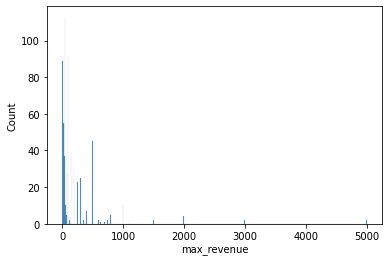

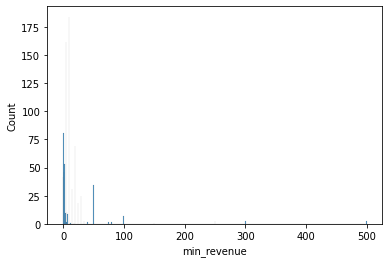

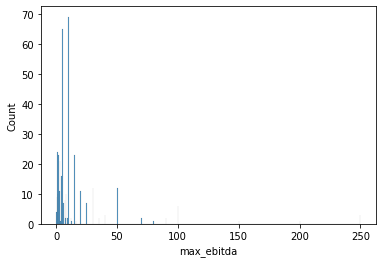

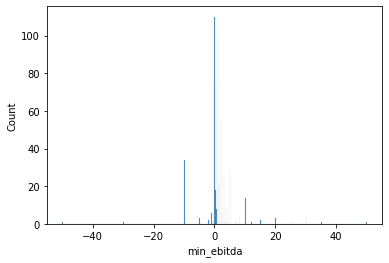

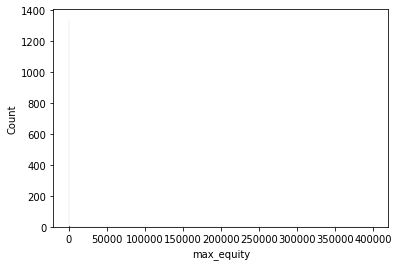

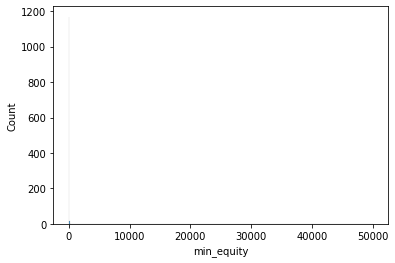

In [416]:
for col in iter_cols:
    g = sns.histplot(invest_profile_financials[col], bins=500)
    #g.set(xlim=(0, 100));
    plt.show()

In [421]:
invest_profile_financials.max_equity.max()

400000.0

#### The Financials will be imputed internally based on specific rules (tbd) and provided by the end of next week (latest: 04.03.2022)

## Deal Feature cleaning

In [487]:
investor_deals = pd.read_excel('investor_deals.xlsx')

In [488]:
investor_deals.head()

,Unnamed: 0,investor_id,name,description,short_description,products_description,company_category_id,number_of_employees,ebit,ebitda,revenue,bs_total,website,origin_country_id,origin_region_id,zipcode,database_import_id,company_source_id,company_state_id,fees_rate,fees_cap,fees_floor,fees_fa,fees_info,inroad,exit_oriented,management_takeover,seriousness,agnostic,margin,crm_id,crm_created_at,crm_updated_at,crm_synced_at,verified_at,verified_by,parent_company_id,ma_history,created_at,updated_at,deleted_at,is_deleted,company_inroad_id,deal_id,company_id,name.1,deal_type_id,deal_stage_id,is_lost,lost_reason_id,comment,target_company_id,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_region_id,target_zipcode,crm_id.1,parent_crm_id,crm_created_at.1,crm_updated_at.1,crm_synced_at.1,created_at.1,updated_at.1,deleted_at.1,is_deleted.1,lead_source_id,lead_prio,type_id,name.2,tx_type_id,name.3,ror_id,ror_name,country_id,iso_alpha2,iso_alpha3,name_en,name_de,name_fr,name_es,phone_country_code,continent_id,region_id,country_id.1,name_en.1,name_de.1,name_fr.1,name_es.1,deal_id.1,deal_id.2,sector_id,created_at.2,updated_at.2,deleted_at.2,is_deleted.2,sector_id.1,name_en.2,name_de.2,xy_id,deal_sector_id,subsector_id,created_at.3,updated_at.3,deleted_at.3,is_deleted.3,subsector_id.1,sector_id.2,name_en.3,name_de.3
0,0,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaN,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,1,1,1301 Sun,4.0,2,1,0.0,NaN,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,-,3611818364,3586205129,2020-12-14 08:35:39,2021-09-09 06:48:37,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 07:59:09,NaN,0,NaN,NaN,2,APPROACH_SENT,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,1,Energy,Energie,1,1,236,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,236,1,Solar power,Solarenergie
1,1,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaN,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,2,1,1220 Supple,4.0,2,1,6.0,NaN,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,3328836718,3292812393,2020-11-06 19:24:26,2021-09-08 08:36:44,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 08:34:03,NaN,0,NaN,NaN,2,APPROACH_SENT,4.0,OTHER,6.0,NO_REGION_FIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,1,Energy,Energie,3,2,236,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,236,1,Solar power,Solarenergie
2,2,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaN,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25:16,NaN,0,1,2,1,1220 Supple,4.0,2,1,6.0,NaN,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,3328836718,3292812393,2020-11-06 19:24:26,2021-09-08 08:36:44,2021-10-14 13:47:07,2021-10-14 13:47:13,2021-10-21 08:34:03,NaN,0,NaN,NaN,2,APPROACH_SENT,4.0,OTHER,6.0,NO_REGION_FIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,1,Energy,Energie,2,2,238,2021-10-14 13:47:13,2021-10-14 13:47:13,NaN,0,238,1,Renewable energy - other,Erneuerbare Energie - sonstige
3,3,1,Greencoat Capital,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,https://www.greencoat-capital.com/,826.0,NaN,NaN,1,NaN,0,0.02,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0,0.0,0.0,1187474059,NaN,2021-12-15 22:04:22,2022-02-20 18:25:15,NaT,NaN,NaN,NaN,2020-01-10 23:00:00,2022-02-20 18:25

In [490]:
investor_deals.columns.to_list()

['Unnamed: 0',
 'investor_id',
 'name',
 'description',
 'short_description',
 'products_description',
 'company_category_id',
 'number_of_employees',
 'ebit',
 'ebitda',
 'revenue',
 'bs_total',
 'website',
 'origin_country_id',
 'origin_region_id',
 'zipcode',
 'database_import_id',
 'company_source_id',
 'company_state_id',
 'fees_rate',
 'fees_cap',
 'fees_floor',
 'fees_fa',
 'fees_info',
 'inroad',
 'exit_oriented',
 'management_takeover',
 'seriousness',
 'agnostic',
 'margin',
 'crm_id',
 'crm_created_at',
 'crm_updated_at',
 'crm_synced_at',
 'verified_at',
 'verified_by',
 'parent_company_id',
 'ma_history',
 'created_at',
 'updated_at',
 'deleted_at',
 'is_deleted',
 'company_inroad_id',
 'deal_id',
 'company_id',
 'name.1',
 'deal_type_id',
 'deal_stage_id',
 'is_lost',
 'lost_reason_id',
 'comment',
 'target_company_id',
 'target_name',
 'target_description',
 'target_revenue',
 'target_ebitda',
 'target_ebit',
 'target_country_id',
 'target_region_id',
 'target_zipcode',


In [494]:
investor_deals = investor_deals[['investor_id', 'name', 
                                'deal_id', 'name.1',
                                'lost_reason_id', 'comment',
                                'target_name', 'target_description', 'target_revenue', 
                                'target_ebitda', 'target_ebit', 'target_country_id', 'name_en',
                                'target_region_id', 'target_zipcode', 'lead_prio', 
                                'type_id', 'name.2', 'is_lost', 'tx_type_id', 'name.3', 'ror_id', 'ror_name',
                                'region_id', 'name_en.1',
                                'sector_id.1', 'name_en.2', 'subsector_id', 'name_en.3']]

In [495]:
investor_deals.head()

,investor_id,name,deal_id,name.1,lost_reason_id,comment,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,name_en,target_region_id,target_zipcode,lead_prio,type_id,name.2,is_lost,tx_type_id,name.3,ror_id,ror_name,region_id,name_en.1,sector_id.1,name_en.2,subsector_id,name_en.3
0,1,Greencoat Capital,1,1301 Sun,0.0,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,2,APPROACH_SENT,1,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,NaN,1,Energy,236,Solar power
1,1,Greencoat Capital,2,1220 Supple,6.0,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,NaN,1,Energy,236,Solar power
2,1,Greencoat Capital,2,1220 Supple,6.0,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,NaN,1,Energy,238,Renewable energy - other
3,1,Greencoat Capital,3,1677 Heat,NaN,NaN,SPH Sustainable Process Heat GmbH,PROJECT HEAT hat eine neue Wärmepumpentechnolo...,0.43,-0.78,-0.78,NaN,NaN,NaN,-,NaN,2,APPROACH_SENT,0,0.0,MAJORITY,NaN,NaN,NaN,NaN,9,Industrial products and services,72,Pumps and compressors
4,1,Greencoat Capital,4,845 Apollo,NaN,NaN,SUMMIQ AG,Fundraising für Renewable Holding,0.00,0.00,0.00,276.0,Germany,3.0,80335,NaN,2,APPROACH_SENT,0,4.0,OTHER,NaN,NaN,3.0,Bavaria,23,Financial Services,182,Other Diversified Financial Services


In [561]:
deals_to_clean = investor_deals.copy()

In [562]:
deals_to_clean.rename(columns={'name':'investor', 'name.1':'deal_name', 'name_en':'target_country_name',
                               'name.2':'deal_phase', 'name.3':'deal_type', 'name_en.1':'target_region_name',
                               'name_en.2':'sector', 'name_en.3':'subsector'}, inplace=True)

In [563]:
deals_to_clean.type_id.value_counts()

2     23760
4      5321
3       379
5       229
0       115
1       112
6        84
7        21
10       20
8         2
9         1
Name: type_id, dtype: int64

In [564]:
deals_to_clean['result'] = deals_to_clean['type_id'].apply(lambda x: 0 if x < 3 else 1)

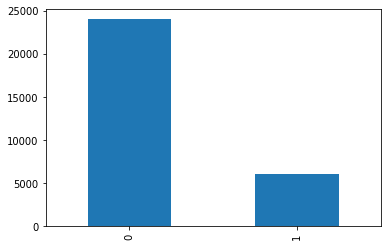

In [565]:
deals_to_clean['result'].value_counts().plot(kind="bar");

In [566]:
deals_to_clean.drop(columns='lost_reason_id', inplace=True)

In [567]:
deals_to_clean.columns

Index(['investor_id', 'investor', 'deal_id', 'deal_name', 'comment',
       'target_name', 'target_description', 'target_revenue', 'target_ebitda',
       'target_ebit', 'target_country_id', 'target_country_name',
       'target_region_id', 'target_zipcode', 'lead_prio', 'type_id',
       'deal_phase', 'is_lost', 'tx_type_id', 'deal_type', 'ror_id',
       'ror_name', 'region_id', 'target_region_name', 'sector_id.1', 'sector',
       'subsector_id', 'subsector', 'result'],
      dtype='object')

In [568]:
deals_to_clean = deals_to_clean[['result', 'investor_id', 'investor', 'deal_id', 'deal_name',
                                 'type_id', 'deal_phase', 'is_lost', 'tx_type_id', 'deal_type', 'ror_id',
                                 'ror_name',  'comment',
                                 'target_name', 'target_description', 'target_revenue', 'target_ebitda',
                                 'target_ebit', 'target_country_id', 'target_country_name',
                                 'target_zipcode', 'region_id', 'target_region_name', 'sector_id.1', 'sector',
                                 'subsector_id', 'subsector']]

In [569]:
deals_to_clean.sample()

,result,investor_id,investor,deal_id,deal_name,type_id,deal_phase,is_lost,tx_type_id,deal_type,ror_id,ror_name,comment,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_country_name,target_zipcode,region_id,target_region_name,sector_id.1,sector,subsector_id,subsector
19054,0,2726,Axos MidCap GmbH-Triginta Capital GmbH,15537,1185 Balance,2,APPROACH_SENT,0,0.0,MAJORITY,NaN,NaN,NaN,FITCOMPANY GMBH,FITCOMPANY bietet strategisches betriebliches ...,5.3,1.2,1.2,276.0,Germany,85748,3.0,Bavaria,11,Professional Services (B2B),91,Other services


#### Cleaning Tasks:

columns to One Hot Encode:
* deal_type
* ror_name
* target_country_name
* target_region_name
* sector

columns to scale:
* target_revenue
* target_ebitda
* target_ebit

columns to drop:
* type_id
* deal_phase
* tx_type_id
* ror_id
* target_name
* target_country_id
* region_id
* sector_id.1
* subsector_id

columns to drop and further investigate:
* comment
* target_description
* target_zipcode (<< future feature: distance target - investor)
* subsector


#### One Hot Encoding

In [570]:
deals_to_clean.shape

(30044, 27)

In [571]:
deals_to_clean[deals_to_clean.deal_type.isna()]['deal_name'].value_counts()

765 Mountain                               28
912 Haustechnik                            22
741 Eastwood                               18
780 Polenor                                17
1120 Breath                                16
889 Skywalker                               5
808 Pipe                                    3
1148 Eco                                    2
1186 Drilling                               2
933 Entwässerung                            2
766 Home\t\t\t                              2
801 Sensor                                  2
1205 Floor | QVM Privatkapital GmbH         2
918 Sunshine                                2
935 Helsinki                                2
1179 Aurum                                  2
891 Feuer                                   2
886 Nikola (Nicola)                         1
804 Label                                   1
688 Linotype                                1
1239 Marseille | Digatus AG                 1
938 Iron                          

In [572]:
deals_to_clean = deals_to_clean[deals_to_clean['deal_type'].notna()]

In [573]:
deals_to_clean['deal_type'].isna().sum()

0

In [574]:
# one hot encode deal types

one_hot_encoder = OneHotEncoder(sparse = False).fit(deals_to_clean[['deal_type']])

new_columns = list(one_hot_encoder.categories_[0])

deals_to_clean[new_columns] = one_hot_encoder.transform(deals_to_clean[['deal_type']])

deals_to_clean.head()

,result,investor_id,investor,deal_id,deal_name,type_id,deal_phase,is_lost,tx_type_id,deal_type,ror_id,ror_name,comment,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_country_name,target_zipcode,region_id,target_region_name,sector_id.1,sector,subsector_id,subsector,DISTRESSED,MAJORITY,MINORITY,OTHER,VC
0,0,1,Greencoat Capital,1,1301 Sun,2,APPROACH_SENT,1,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0
1,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0
2,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,238,Renewable energy - other,0.0,0.0,0.0,1.0,0.0
3,0,1,Greencoat Capital,3,1677 Heat,2,APPROACH_SENT,0,0.0,MAJORITY,NaN,NaN,NaN,SPH Sustainable Process Heat GmbH,PROJECT HEAT hat eine neue Wärmepumpentechnolo...,0.43,-0.78,-0.78,NaN,NaN,-,NaN,NaN,9,Industrial products and services,72,Pumps and compressors,0.0,1.0,0.0,0.0,0.0
4,0,1,Greencoat Capital,4,845 Apollo,2,APPROACH_SENT,0,4.0,OTHER,NaN,NaN,NaN,SUMMIQ AG,Fundraising für Renewable Holding,0.00,0.00,0.00,276.0,Germany,80335,3.0,Bavaria,23,Financial Services,182,Other Diversified Financial Services,0.0,0.0,0.0,1.0,0.0


In [575]:
deals_to_clean.shape

(29898, 32)

In [576]:
deals_to_clean.ror_name.isna().sum()

17899

In [577]:
deals_to_clean.ror_name.replace(np.nan, 'NO_RESPONSE', inplace=True)

In [578]:
# one hot encode ror_name

one_hot_encoder = OneHotEncoder(sparse = False).fit(deals_to_clean[['ror_name']])

new_columns = list(one_hot_encoder.categories_[0])

deals_to_clean[new_columns] = one_hot_encoder.transform(deals_to_clean[['ror_name']])

deals_to_clean.head()

,result,investor_id,investor,deal_id,deal_name,type_id,deal_phase,is_lost,tx_type_id,deal_type,ror_id,ror_name,comment,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_country_name,target_zipcode,region_id,target_region_name,sector_id.1,sector,subsector_id,subsector,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL
0,0,1,Greencoat Capital,1,1301 Sun,2,APPROACH_SENT,1,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,238,Renewable energy - other,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0,1,Greencoat Capital,3,1677 Heat,2,APPROACH_SENT,0,0.0,MAJORITY,NaN,NO_RESPONSE,NaN,SPH Sustainable Process Heat GmbH,PROJECT HEAT hat eine neue Wärmepumpentechnolo...,0.43,-0.78,-0.78,NaN,NaN,-,NaN,NaN,9,Industrial products and services,72,Pumps and compressors,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1,Greencoat Capital,4,845 Apollo,2,APPROACH_SENT,0,4.0,OTHER,NaN,NO_RESPONSE,NaN,SUMMIQ AG,Fundraising für Renewable Holding,0.00,0.00,0.00,276.0,Germany,80335,3.0,Bavaria,23,Financial Services,182,Other Diversified Financial Services,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [579]:
deals_to_clean.sector.isna().sum()

0

In [580]:
# one hot encode sector

one_hot_encoder = OneHotEncoder(sparse = False).fit(deals_to_clean[['sector']])

new_columns = list(one_hot_encoder.categories_[0])

deals_to_clean[new_columns] = one_hot_encoder.transform(deals_to_clean[['sector']])

deals_to_clean.head()

,result,investor_id,investor,deal_id,deal_name,type_id,deal_phase,is_lost,tx_type_id,deal_type,ror_id,ror_name,comment,target_name,target_description,target_revenue,target_ebitda,target_ebit,target_country_id,target_country_name,target_zipcode,region_id,target_region_name,sector_id.1,sector,subsector_id,subsector,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,0,1,Greencoat Capital,1,1301 Sun,2,APPROACH_SENT,1,4.0,OTHER,0.0,NOT_SPECIFIED,NaN,Sun [Target],•\t350MWp of solar photovoltaic project assets...,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,236,Solar power,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,Greencoat Capital,2,1220 Supple,2,APPROACH_SENT,1,4.0,OTHER,6.0,NO_REGION_FIT,NaN,Supple [Target],Solaranlage in Kreta,57.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Energy,238,Renewable energy - other,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,Greencoat Capital,3,1677 Heat,2,APPROACH_SENT,0,0.0,MAJORITY,NaN,NO_RESPONSE,NaN,SPH Sustainable Process Heat GmbH,PROJECT HEAT hat eine neue Wärmepumpentechnolo...,0.43,-0.78,-0.78,NaN,NaN,-,NaN,NaN,9,Industrial products and services,72,Pumps and compressors,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,Greencoat Capital,4,845 Apollo,2,APPROACH_SENT,0,4.0,OTHER,NaN,NO_RESPONSE,NaN,SUMMIQ AG,Fundraising für Renewable Holding,0.00,0.00,0.00,276.0,Germany,80335,3.0,Bavaria,23,Financial Services,182,Other Diversified Financial Services,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


consider: sectors_encoding_no_exclude_clean = sectors_encoding_no_exclude_clean.groupby('investor_id').max().reset_index()

In [582]:
deals_to_clean.target_region_name.value_counts()

Bavaria                   4987
North Rhine-Westphalia    4161
Baden-Württemberg         3280
Hesse                     2283
Lower Saxony              2093
Berlin                     976
Rhineland-Palatinate       916
Hamburg                    867
Saxony-Anhalt              544
Schleswig-Holstein         427
Thuringia                  395
Brandenburg                329
Saarland                   280
Bremen                     194
Mecklenburg-Vorpommern      94
Saxony                      13
Name: target_region_name, dtype: int64

In [583]:
deals_to_clean.target_region_name.isna().sum()

8059

##### Question:
- What to do when no target_region is available? Is it meaningful to impute as "no_region_available"? 

#### Columns to drop

In [585]:
deals_to_clean_1 = deals_to_clean.copy()

In [584]:
cols_to_drop = ['type_id', 'deal_phase', 'tx_type_id', 'ror_id', 'target_name',
                'target_country_id', 'region_id', 'sector_id.1', 'subsector_id']

In [586]:
deals_to_clean_1.drop(columns=cols_to_drop, inplace=True)
deals_to_clean_1.columns

Index(['result', 'investor_id', 'investor', 'deal_id', 'deal_name', 'is_lost',
       'deal_type', 'ror_name', 'comment', 'target_description',
       'target_revenue', 'target_ebitda', 'target_ebit', 'target_country_name',
       'target_zipcode', 'target_region_name', 'sector', 'subsector',
       'DISTRESSED', 'MAJORITY', 'MINORITY', 'OTHER', 'VC', 'NOT_SPECIFIED',
       'NO_CAPACITY', 'NO_MA_PLANNED', 'NO_REGION_FIT', 'NO_RESPONSE',
       'NO_STRATEGIC_FIT', 'TOO_EXPENSIVE', 'TOO_SMALL', 'Agriculture',
       'Automotive', 'Biotechnology & Life Sciences', 'Chemicals',
       'Computer Hardware & Equipment', 'Construction',
       'Consumer Goods & Apparel', 'Defense', 'Electronics', 'Energy',
       'Financial Services', 'Food & Beverages', 'Food & Staples Retailing',
       'Health Care Equipment & Services', 'IT services',
       'Industrial automation', 'Industrial products and services',
       'Insurance', 'Internet/ecommerce', 'Leisure & consumer services',
       'Manufact

In [587]:
deals_to_clean_1.sample()

,result,investor_id,investor,deal_id,deal_name,is_lost,deal_type,ror_name,comment,target_description,target_revenue,target_ebitda,target_ebit,target_country_name,target_zipcode,target_region_name,sector,subsector,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
13388,0,2542,Koru Nachfolge GmbH,11561,653 Avantgarde,1,MAJORITY,NO_STRATEGIC_FIT,NaN,Möbelsysteme\n,13.2,1.6,1.1,Germany,33397,North Rhine-Westphalia,Manufacturing (other),Furniture industry,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [588]:
deals_final = deals_to_clean_1.copy()

In [589]:
deals_final.drop(columns=['investor', 'deal_name', 'deal_type', 'ror_name', 'comment',
                          'target_description', 'target_country_name', 'target_zipcode',
                          'target_region_name', 'sector', 'subsector'], inplace=True)

In [590]:
deals_final.sample()

,result,investor_id,deal_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
22421,0,3262,18134,1,28.7,-4.0,-4.3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [591]:
deals_final.shape

(29898, 53)

(-10.0, 200.0)

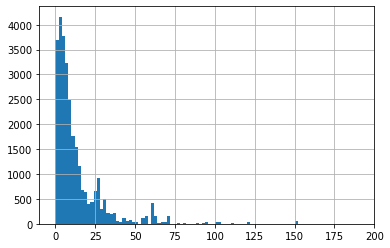

In [606]:
deals_final.target_revenue.hist(bins=1000)
plt.xlim(-10,200)

(-10.0, 20.0)

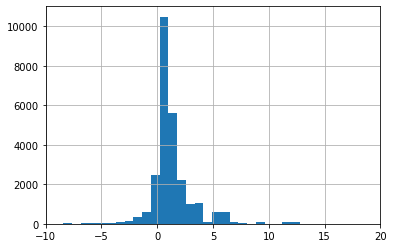

In [622]:
deals_final.target_ebitda.hist(bins=100)
plt.xlim(-10,20)

(-10.0, 20.0)

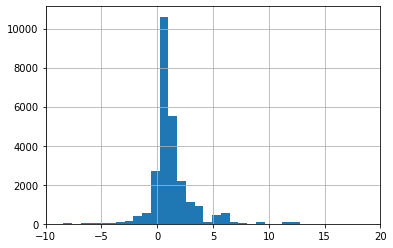

In [623]:
deals_final.target_ebit.hist(bins=100)
plt.xlim(-10,20)

In [618]:
deals_final['target_ebit'] = np.where(deals_final['target_ebit'].isna(), deals_final['target_ebitda'], deals_final['target_ebit'])

In [619]:
deals_final['target_ebit'].isna().sum()

3986

In [621]:
deals_final['target_ebitda'].isna().sum()

3986

In [620]:
deals_final['target_ebitda'] = np.where(deals_final['target_ebitda'].isna(), deals_final['target_ebit'], deals_final['target_ebitda'])

In [624]:
deals_final['target_revenue'].isna().sum()

1107

In [634]:
deals_final = deals_final[deals_final['target_ebitda'].notna()]

In [635]:
deals_final.target_revenue.isna().sum()

189

In [636]:
deals_final = deals_final[deals_final['target_revenue'].notna()]

In [638]:
deals_final = deals_final[deals_final['target_ebitda'] != 0]

In [639]:
deals_final.head()

,result,investor_id,deal_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
3,0,1,3,0,0.43,-0.78,-0.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,7,6,0,60.00,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,7,6,0,60.00,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,7,6,0,60.00,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,7,6,0,60.00,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [640]:
deals_final.shape

(25192, 53)

In [648]:
deals_final_2 = deals_final.copy()

In [649]:
deals_final_2 = deals_final_2.groupby('deal_id').max().reset_index()

In [650]:
deals_final_2.investor_id.nunique()

1578

In [651]:
deals_final_2

,deal_id,result,investor_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,3,0,1,0,0.43,-0.78,-0.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0,7,0,60.00,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,7,0,5.50,1.90,1.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0,7,1,62.30,5.10,3.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,1,7,1,6.50,1.20,1.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17028,29692,1,9992,0,5.60,0.20,0.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17029,29693,0,9992,0,10.00,0.30,0.30,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17030,29695,0,9992,1,2.00,0.25,0.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17031,29696,0,9992,0,6.00,0.50,0.50,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


(0.0, 20.0)

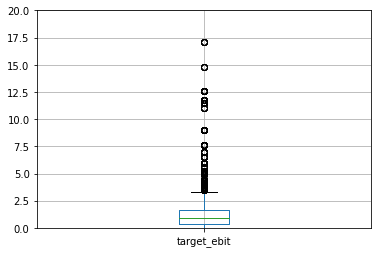

In [658]:
deals_final_2.boxplot('target_ebit')
plt.ylim(0,20)

In [655]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler() # Instanciate Robust Scaler

r_scaler.fit(deals_final_2[['target_revenue']]) # Fit scaler to feature

deals_final_2['target_revenue'] = r_scaler.transform(deals_final_2[['target_revenue']]) #Scale

deals_final_2.head()

,deal_id,result,investor_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,3,0,1,0,-0.670000,-0.78,-0.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0,7,0,4.745455,6.00,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,7,0,-0.209091,1.90,1.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0,7,1,4.954545,5.10,3.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,1,7,1,-0.118182,1.20,1.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [659]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler() # Instanciate Robust Scaler

r_scaler.fit(deals_final_2[['target_ebitda']]) # Fit scaler to feature

deals_final_2['target_ebitda'] = r_scaler.transform(deals_final_2[['target_ebitda']]) #Scale

deals_final_2.head()

,deal_id,result,investor_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,3,0,1,0,-0.670000,-1.333333,-0.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0,7,0,4.745455,4.047619,6.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,7,0,-0.209091,0.793651,1.90,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0,7,1,4.954545,3.333333,3.60,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,1,7,1,-0.118182,0.238095,1.20,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [660]:
from sklearn.preprocessing import RobustScaler

r_scaler = RobustScaler() # Instanciate Robust Scaler

r_scaler.fit(deals_final_2[['target_ebit']]) # Fit scaler to feature

deals_final_2['target_ebit'] = r_scaler.transform(deals_final_2[['target_ebit']]) #Scale

deals_final_2.head()

,deal_id,result,investor_id,is_lost,target_revenue,target_ebitda,target_ebit,DISTRESSED,MAJORITY,MINORITY,OTHER,VC,NOT_SPECIFIED,NO_CAPACITY,NO_MA_PLANNED,NO_REGION_FIT,NO_RESPONSE,NO_STRATEGIC_FIT,TOO_EXPENSIVE,TOO_SMALL,Agriculture,Automotive,Biotechnology & Life Sciences,Chemicals,Computer Hardware & Equipment,Construction,Consumer Goods & Apparel,Defense,Electronics,Energy,Financial Services,Food & Beverages,Food & Staples Retailing,Health Care Equipment & Services,IT services,Industrial automation,Industrial products and services,Insurance,Internet/ecommerce,Leisure & consumer services,Manufacturing (other),Media,Mining,Pharmaceuticals,Professional Services (B2B),Real Estate,Retailing,Semiconductors & Semiconductor Equipment,Software & Services,Telecommunication Hardware,Telecommunication Services,Transportation,Utilities
0,3,0,1,0,-0.670000,-1.333333,-1.400000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0,7,0,4.745455,4.047619,4.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,7,0,-0.209091,0.793651,0.833333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,0,7,1,4.954545,3.333333,2.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,1,7,1,-0.118182,0.238095,0.250000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [661]:
deals_final_2.shape

(17033, 53)

In [662]:
deals_final_2.investor_id.nunique()

1578

##### final df to merge: deals_final_2